In [7]:
import os
import re
import json
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

# Rohstring
verzeichnis = r"Untitled Folder\Untitled Folder\records_raw.csv"

In [118]:
# ----------- 1) Dateien einsammeln und Name parsen -----------------
verzeichnis = "Untitled Folder/Untitled Folder"
name_re = re.compile(r'^(aws|azure|gcp)_(?:([A-Za-z0-9-]+)_)?(\d+)_(cold|warm)_results_(\d+)\.json$', re.IGNORECASE)

def parse_context(base):
    m = name_re.match(base)
    if not m:
        return None
    provider = m.group(1).lower()
    region = m.group(2)  # kann None sein
    workload = int(m.group(3))
    phase = m.group(4).lower()
    use_case = int(m.group(5))
    return provider, region, workload, phase, use_case

dateien = [f for f in os.listdir(verzeichnis) if f.lower().endswith('.json')]
matches = [base for base in dateien if parse_context(base) is not None]
print(f"Gefundene JSONs im Ordner: {len(dateien)}")
print(f"Dateien passend zum Schema: {len(matches)}")
print(matches[:10])
if not matches:
    raise SystemExit("Keine passenden Dateien gefunden. Prüfe Ordnernamen oder Dateinamen.")

Gefundene JSONs im Ordner: 123
Dateien passend zum Schema: 123
['aws_eu_110_cold_results_1024.json', 'aws_eu_110_cold_results_2048.json', 'aws_eu_110_cold_results_256.json', 'aws_eu_110_cold_results_3008.json', 'aws_eu_110_cold_results_512.json', 'aws_eu_110_warm_results_1024.json', 'aws_eu_110_warm_results_2048.json', 'aws_eu_110_warm_results_256.json', 'aws_eu_110_warm_results_3008.json', 'aws_eu_110_warm_results_512.json']


In [119]:
# Pfad, in dem die JSONs liegen (ggf. anpassen)
verzeichnis = "Desktop/Untitled Folder/Untitled Folder"
files = [f for f in os.listdir(verzeichnis) if f.lower().endswith('.json')]
matches = [base for base in dateien if parse_context(base) is not None]

# Manifest aufbereiten
rows = []
pat = re.compile(r"_((?:warm)|(?:cold))_results_(\d+)\.json$")
for fn in files:
    m = pat.search(os.path.basename(fn))
    phase = m.group(1) if m else ""
    memory_mb = int(m.group(2)) if m else None
    rows.append({"filename": fn, "phase": phase, "memory_mb": memory_mb})

manifest = pd.DataFrame(rows).sort_values(["phase","memory_mb"]).reset_index(drop=True)
display(manifest)

# Persistieren, damit nachfolgende Schritte einen stabilen Einstiegspunkt haben
manifest_path = os.path.join(verzeichnis, "input_manifest.csv")
manifest.to_csv(manifest_path, index=False)
manifest_path

,filename,phase,memory_mb
0,aws_eu_110_cold_results_256.json,cold,256
1,aws_eu_120_cold_results_256.json,cold,256
2,aws_eu_220_cold_results_256.json,cold,256
3,aws_eu_311_cold_results_256.json,cold,256
4,aws_us_110_cold_results_256.json,cold,256
...,...,...,...
118,aws_us_220_warm_results_3008.json,warm,3008
119,aws_us_311_warm_results_3008.json,warm,3008
120,azure_120_warm_results_3008.json,warm,3008
121,azure_220_warm_results_3008.json,warm,3008


'Desktop/Untitled Folder/Untitled Folder\\input_manifest.csv'

In [120]:
def _safe_get(d, path, default=None):
    cur = d
    for k in path:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

def parse_sebs_file(path, phase, memory_mb):
    """
    Liest eine SEBS-JSON-Datei und gibt eine Liste flacher Records (dict) zurück.
    Die Funktion ist robust gegenüber fehlenden Feldern.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    invocations_root = data.get("_invocations", {})
    records = []
    
    # Jede Funktion (hier: ein Key wie 'sebs_..._uploader_python_3_11_x64')
    for func_name, func_invocations in invocations_root.items():
        # Jede Invocation (Key ist request_id)
        for req_id, payload in func_invocations.items():
            # times
            times = payload.get("times", {}) or {}
            t_client = times.get("client")
            t_benchmark = times.get("benchmark")
            t_http_first_byte = times.get("http_first_byte_return")
            t_http_startup = times.get("http_startup")
            t_initialization = times.get("initialization")

            # output/result/measurement
            output = payload.get("output", {}) or {}
            is_cold_flag = output.get("is_cold")
            result = output.get("result", {}) or {}
            measurement = result.get("measurement", {}) or {}
            compute_time = measurement.get("compute_time")
            upload_time = measurement.get("upload_time")
            download_time = measurement.get("download_time")

            # stats
            stats = payload.get("stats", {}) or {}
            cold_start_stats = stats.get("cold_start")

            # begin/end from output
            begin_ts = output.get("begin")
            end_ts = output.get("end")
            
            rec = {
                "function": func_name,
                "request_id": req_id,
                "phase": phase,
                "memory_mb": memory_mb,
                "is_cold_flag": is_cold_flag,
                "cold_start_stats": cold_start_stats,
                "begin_ts": begin_ts,
                "end_ts": end_ts,
                "compute_time": compute_time,
                "upload_time": upload_time,
                "download_time": download_time,
                "client_time": t_client,
                "benchmark_time": t_benchmark,
                "http_first_byte_return": t_http_first_byte,
                "http_startup": t_http_startup,
                "initialization_time": t_initialization,
                # Roh-JSON Pfad für Repro
                "source_file": os.path.basename(path),
            }
            records.append(rec)
    return records

In [121]:
from pathlib import Path

missing = []
all_records = []
for _, row in manifest.iterrows():
    fn = Path(verzeichnis) / row["filename"]
    if not fn.exists():
        missing.append(str(fn))
        continue
    all_records.extend(
        parse_sebs_file(str(fn), phase=row["phase"], memory_mb=int(row["memory_mb"]))
    )

if missing:
    print("Fehlende Dateien:\n- " + "\n- ".join(missing))


In [122]:
# Manifest laden (stabiler Einstiegspunkt)
manifest = pd.read_csv(os.path.join(verzeichnis, "input_manifest.csv"))



In [123]:

all_records = []
for _, row in manifest.iterrows():
    fn = os.path.join(verzeichnis, row["filename"])
    recs = parse_sebs_file(fn, phase=row["phase"], memory_mb=int(row["memory_mb"]))
    all_records.extend(recs)


In [124]:
df_raw = pd.DataFrame(all_records)
display(df_raw.head(10))
print(f"Rows: {len(df_raw):,}")

# Persistieren (Rohdaten)
raw_csv_path = os.path.join(verzeichnis, "records_raw.csv")
df_raw.to_csv(raw_csv_path, index=False)
raw_csv_path


,function,request_id,phase,memory_mb,is_cold_flag,cold_start_stats,begin_ts,end_ts,compute_time,upload_time,download_time,client_time,benchmark_time,http_first_byte_return,http_startup,initialization_time,source_file
0,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0021e035-3926-44af-ba12-212fd06491c5,cold,256,True,True,1747842241.053078,1747842241.608053,NaN,NaN,NaN,1120943,554975,1.176356,0.280711,0,aws_eu_110_cold_results_256.json
1,sebs_aca4322a_110_dynamic_html_python_3_11_x64,03608bb3-e171-456b-a41d-b8354eb0e68c,cold,256,True,True,1747842131.504524,1747842132.056397,NaN,NaN,NaN,1209783,551873,1.209392,0.280229,0,aws_eu_110_cold_results_256.json
2,sebs_aca4322a_110_dynamic_html_python_3_11_x64,049ea183-296c-468d-9efb-68e7bbb58e40,cold,256,True,True,1747842227.528749,1747842228.062766,NaN,NaN,NaN,1166794,534017,1.222556,0.292411,0,aws_eu_110_cold_results_256.json
3,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0514287f-f5a9-4134-aad0-7d5f40927b9c,cold,256,True,True,1747842131.524563,1747842132.087758,NaN,NaN,NaN,1241640,563195,1.241188,0.289042,0,aws_eu_110_cold_results_256.json
4,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0521a926-9410-45e0-9af7-f3465756edef,cold,256,True,True,1747842213.749854,1747842214.284605,NaN,NaN,NaN,1112701,534751,1.112438,0.260746,0,aws_eu_110_cold_results_256.json
5,sebs_aca4322a_110_dynamic_html_python_3_11_x64,065c4378-61a4-4dbc-9616-0e2a9f259384,cold,256,True,True,1747842117.824779,1747842118.355350,NaN,NaN,NaN,1069610,530571,1.162853,0.266973,0,aws_eu_110_cold_results_256.json
6,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0751cdd9-8382-4b84-b707-66be90d2c220,cold,256,True,True,1747842186.403183,1747842186.935027,NaN,NaN,NaN,1119013,531844,1.161399,0.268997,0,aws_eu_110_cold_results_256.json
7,sebs_aca4322a_110_dynamic_html_python_3_11_x64,07846f5b-a076-4930-a797-06b4143a2664,cold,256,True,True,1747842350.483815,1747842351.055383,NaN,NaN,NaN,1144777,571568,1.177981,0.282110,0,aws_eu_110_cold_results_256.json
8,sebs_aca4322a_110_dynamic_html_python_3_11_x64,08090fe2-c1ba-4fe5-afb8-3d083432fd9d,cold,256,True,True,1747842254.831448,1747842255.422056,NaN,NaN,NaN,1229097,590608,1.228843,0.273317,0,aws_eu_110_cold_results_256.json
9,sebs_aca4322a_110_dynamic_html_python_3_11_x64,086ba229-d6cf-4396-bd8c-b5e03151d7df,cold,256,True,True,1747842104.214902,1747842104.760721,NaN,NaN,NaN,1153463,545819,1.179258,0.269220,0,aws_eu_110_cold_results_256.json


Rows: 24,904


'Desktop/Untitled Folder/Untitled Folder\\records_raw.csv'

In [125]:
df = df_raw.copy()

# Numerische Felder sauber konvertieren
num_cols = [
    "compute_time", "upload_time", "download_time",
    "client_time", "benchmark_time", "http_first_byte_return",
    "http_startup", "initialization_time"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Mikrosekunden -> Millisekunden
for c in num_cols:
    df[c + "_ms"] = df[c] / 1000.0

# IO-Teil und Gesamtdauer
df["io_time_ms"] = df["upload_time_ms"].fillna(0) + df["download_time_ms"].fillna(0)

# "Echte" Cold/Warm pro Invocation
# - is_cold_flag kommt aus output.is_cold (True/False)
# - cold_start_stats kommt aus stats.cold_start (True/False)
# Wir priorisieren output.is_cold, fallback auf stats.cold_start, sonst Phase-Heuristik.
df["is_cold"] = np.where(
    df["is_cold_flag"].notna(), df["is_cold_flag"],
    np.where(df["cold_start_stats"].notna(), df["cold_start_stats"], df["phase"].eq("cold"))
).astype(bool)

# Handliche Spaltennamen
df = df.rename(columns={
    "client_time_ms": "client_ms",
    "compute_time_ms": "compute_ms",
    "upload_time_ms": "upload_ms",
    "download_time_ms": "download_ms",
    "benchmark_time_ms": "benchmark_ms",
})

keep_cols = [
    "function", "request_id", "phase", "memory_mb", "is_cold",
    "client_ms", "compute_ms", "upload_ms", "download_ms",
    "io_time_ms", "benchmark_ms", "http_first_byte_return_ms",
    "http_startup_ms", "initialization_time_ms",
    "begin_ts", "end_ts", "source_file"
]
df = df[[c for c in keep_cols if c in df.columns]]

display(df.head(10))


,function,request_id,phase,memory_mb,is_cold,client_ms,compute_ms,upload_ms,download_ms,io_time_ms,benchmark_ms,http_first_byte_return_ms,http_startup_ms,initialization_time_ms,begin_ts,end_ts,source_file
0,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0021e035-3926-44af-ba12-212fd06491c5,cold,256,True,1120.943,NaN,NaN,NaN,0.0,554.975,0.001176,0.000281,0.0,1747842241.053078,1747842241.608053,aws_eu_110_cold_results_256.json
1,sebs_aca4322a_110_dynamic_html_python_3_11_x64,03608bb3-e171-456b-a41d-b8354eb0e68c,cold,256,True,1209.783,NaN,NaN,NaN,0.0,551.873,0.001209,0.000280,0.0,1747842131.504524,1747842132.056397,aws_eu_110_cold_results_256.json
2,sebs_aca4322a_110_dynamic_html_python_3_11_x64,049ea183-296c-468d-9efb-68e7bbb58e40,cold,256,True,1166.794,NaN,NaN,NaN,0.0,534.017,0.001223,0.000292,0.0,1747842227.528749,1747842228.062766,aws_eu_110_cold_results_256.json
3,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0514287f-f5a9-4134-aad0-7d5f40927b9c,cold,256,True,1241.640,NaN,NaN,NaN,0.0,563.195,0.001241,0.000289,0.0,1747842131.524563,1747842132.087758,aws_eu_110_cold_results_256.json
4,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0521a926-9410-45e0-9af7-f3465756edef,cold,256,True,1112.701,NaN,NaN,NaN,0.0,534.751,0.001112,0.000261,0.0,1747842213.749854,1747842214.284605,aws_eu_110_cold_results_256.json
5,sebs_aca4322a_110_dynamic_html_python_3_11_x64,065c4378-61a4-4dbc-9616-0e2a9f259384,cold,256,True,1069.610,NaN,NaN,NaN,0.0,530.571,0.001163,0.000267,0.0,1747842117.824779,1747842118.355350,aws_eu_110_cold_results_256.json
6,sebs_aca4322a_110_dynamic_html_python_3_11_x64,0751cdd9-8382-4b84-b707-66be90d2c220,cold,256,True,1119.013,NaN,NaN,NaN,0.0,531.844,0.001161,0.000269,0.0,1747842186.403183,1747842186.935027,aws_eu_110_cold_results_256.json
7,sebs_aca4322a_110_dynamic_html_python_3_11_x64,07846f5b-a076-4930-a797-06b4143a2664,cold,256,True,1144.777,NaN,NaN,NaN,0.0,571.568,0.001178,0.000282,0.0,1747842350.483815,1747842351.055383,aws_eu_110_cold_results_256.json
8,sebs_aca4322a_110_dynamic_html_python_3_11_x64,08090fe2-c1ba-4fe5-afb8-3d083432fd9d,cold,256,True,1229.097,NaN,NaN,NaN,0.0,590.608,0.001229,0.000273,0.0,1747842254.831448,1747842255.422056,aws_eu_110_cold_results_256.json
9,sebs_aca4322a_110_dynamic_html_python_3_11_x64,086ba229-d6cf-4396-bd8c-b5e03151d7df,cold,256,True,1153.463,NaN,NaN,NaN,0.0,545.819,0.001179,0.000269,0.0,1747842104.214902,1747842104.760721,aws_eu_110_cold_results_256.json


In [126]:
print(df.groupby(["phase","memory_mb","is_cold"])["request_id"].count())
print()
print("Fehlende Kombinationen:", df.groupby(["phase","memory_mb"])["request_id"].count().unstack(fill_value=0).eq(0).any().any())

phase  memory_mb  is_cold
cold   256        True       2225
       512        True       2225
       1024       True       2427
       2048       True       2442
       3008       True       1632
warm   256        False      2830
       512        False      2835
       1024       False      3036
       2048       False      3038
       3008       False      2214
Name: request_id, dtype: int64

Fehlende Kombinationen: False


In [127]:
def percentiles(s):
    return pd.Series({
        "count": s.count(),
        "mean": s.mean(),
        "std": s.std(),
        "p50": s.quantile(0.50),
        "p90": s.quantile(0.90),
        "p99": s.quantile(0.99),
        "min": s.min(),
        "max": s.max(),
    })

group_cols = ["phase", "memory_mb"]

agg_client = df.groupby(group_cols)["client_ms"].apply(percentiles).unstack()
agg_compute = df.groupby(group_cols)["compute_ms"].apply(percentiles).unstack()
agg_io = df.groupby(group_cols)["io_time_ms"].apply(percentiles).unstack()

display(agg_client.round(3))
display(agg_compute.round(3))
display(agg_io.round(3))

# Persistieren
out_dir = verzeichnis
agg_client.to_csv(os.path.join(out_dir, "summary_client_ms.csv"))
agg_compute.to_csv(os.path.join(out_dir, "summary_compute_ms.csv"))
agg_io.to_csv(os.path.join(out_dir, "summary_io_ms.csv"))


count      mean       std       p50        p90        p99      min        max
phase memory_mb                                                                                
cold  256        2225.0  8534.726  7396.892  6947.640  21800.229  22647.077  210.409  26105.245
      512        2225.0  4705.464  3841.744  4033.644  11175.179  11605.847  202.901  51474.153
      1024       2427.0  3589.381  2661.377  3722.373   6224.688  11379.495  205.396  22815.378
      2048       2442.0  3021.322  2607.970  3200.540   5487.086  14717.594  203.115  23017.589
      3008       1632.0  2036.672  1177.494  1308.108   3363.479   3882.535  580.747   4674.260
warm  256        2830.0  4227.084  6020.357   719.698  16250.777  17693.218  187.278  66620.661
      512        2835.0  2568.802  4345.644   723.673   7989.475   8307.146  187.142  67044.194
      1024       3036.0  2560.783  4312.493   769.442   5430.998  12209.708  189.171  69190.448
      2048       3038.0  2651.640  7059.101   728.568   3800.181  65185.645  187.605  70646.524
      3008       2214.0  2302.052  5217.842   766.420   3023.407  16783.920  385.489  70362.799

count      mean       std       p50        p90        p99      min        max
phase memory_mb                                                                                
cold  256        1612.0  5452.127  6859.830  3137.120  17383.834  17923.042  108.051  18223.301
      512        1605.0  2723.323  3433.529  1538.759   8698.767   8943.938   76.878   9127.133
      1024       1811.0  1645.398  1833.419   783.371   4382.964   5076.595   40.412   5603.646
      2048       1823.0   937.886   994.747   452.246   2416.514   3000.380   32.427   3316.428
      3008       1217.0   703.883   694.575   446.228   1684.388   1931.436   31.018   2296.347
warm  256        2020.0  3933.512  5690.295  1045.610  15359.625  16438.603    0.180  17357.132
      512        2018.0  1913.399  2693.305   555.938   7172.479   7377.073    0.204   7714.364
      1024       2431.0  1680.181  2200.271   732.013   4390.090   9688.229    0.176  13715.868
      2048       2432.0  1194.820  1953.559   421.684   2866.603   9774.141    0.165  16631.446
      3008       1808.0  1247.819  2668.191   417.880   3762.565  13766.107    0.173  19987.875

count      mean       std      p50       p90       p99  min        max
phase memory_mb                                                                         
cold  256        2225.0  1221.168  1498.084  299.220  3559.651  4963.876  0.0   6047.368
      512        2225.0   779.251  1340.592  213.484  2203.433  2894.165  0.0  45458.413
      1024       2427.0   679.587   840.582  242.554  2015.546  2493.091  0.0   5629.940
      2048       2442.0   632.597   813.138  227.232  1959.012  2433.888  0.0   6654.985
      3008       1632.0   563.864   777.757  181.776  1899.214  2265.113  0.0   3167.954
warm  256        2830.0   889.012  1347.835  164.818  3151.168  4442.639  0.0   8212.854
      512        2835.0   568.386   861.537  135.899  2106.612  2616.195  0.0   5451.794
      1024       3036.0   545.003   729.707  159.298  1877.107  2165.198  0.0   4160.775
      2048       3038.0   510.711   697.020  176.964  1824.614  2099.443  0.0   4888.924
      3008       2214.0   455.911   678.492  136.444  1804.058  2034.008  0.0   3952.861

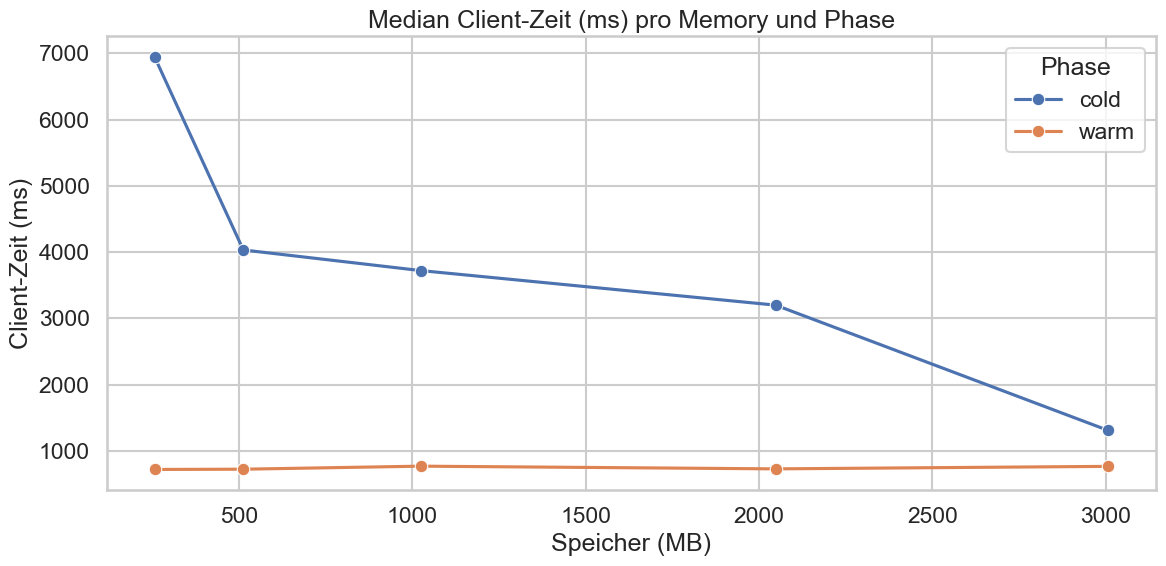

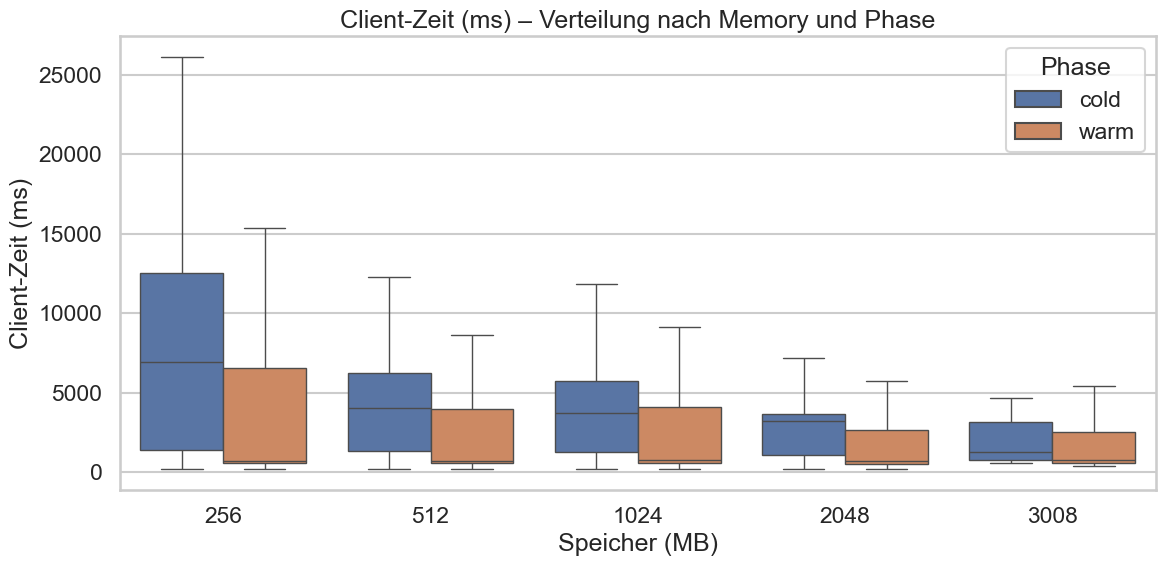

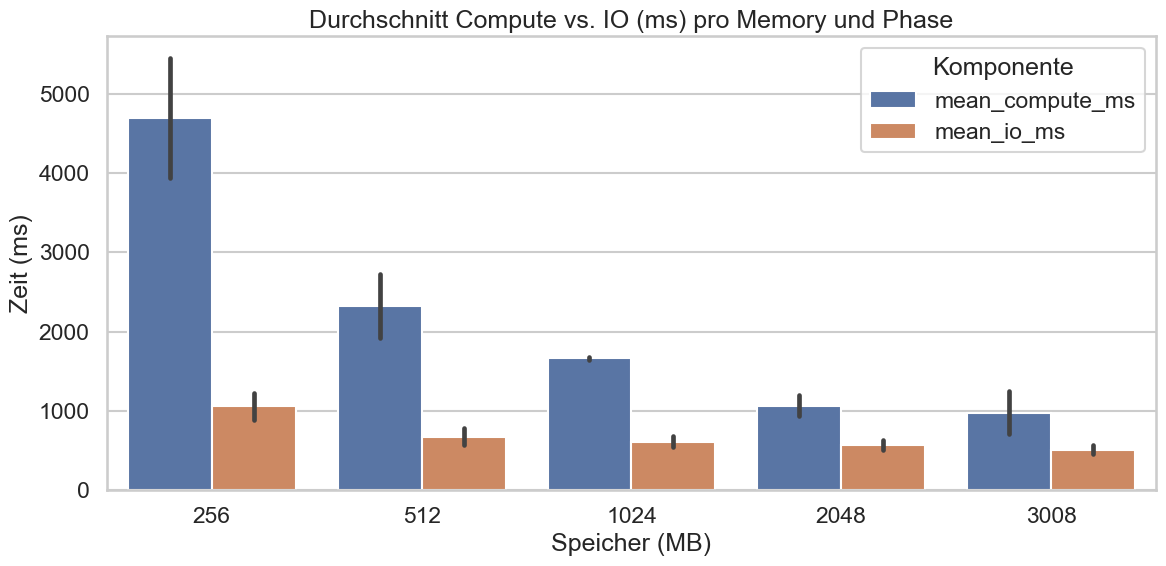

In [128]:
# 1) Median End-to-End (client_ms) vs. Memory nach Phase
med = df.groupby(["phase","memory_mb"])["client_ms"].median().reset_index()
fig = sns.lineplot(data=med, x="memory_mb", y="client_ms", hue="phase", marker="o")
plt.title("Median Client-Zeit (ms) pro Memory und Phase")
plt.xlabel("Speicher (MB)")
plt.ylabel("Client-Zeit (ms)")
plt.legend(title="Phase")
plt.tight_layout()
plt.show()

# 2) Boxplot: Verteilung Client-Zeit je Memory und Phase
fig = sns.boxplot(data=df, x="memory_mb", y="client_ms", hue="phase", showfliers=False)
plt.title("Client-Zeit (ms) – Verteilung nach Memory und Phase")
plt.xlabel("Speicher (MB)")
plt.ylabel("Client-Zeit (ms)")
plt.legend(title="Phase")
plt.tight_layout()
plt.show()

# 3) Gestapelte Balken: Mittelwerte Compute vs. IO je Gruppe
mean_parts = (
    df.groupby(["phase","memory_mb"])
      .agg(mean_compute_ms=("compute_ms","mean"),
           mean_io_ms=("io_time_ms","mean"))
      .reset_index()
)
mean_parts_melt = mean_parts.melt(id_vars=["phase","memory_mb"], value_vars=["mean_compute_ms","mean_io_ms"],
                                  var_name="komponente", value_name="ms")
fig = sns.barplot(data=mean_parts_melt, x="memory_mb", y="ms", hue="komponente")
plt.title("Durchschnitt Compute vs. IO (ms) pro Memory und Phase")
plt.xlabel("Speicher (MB)")
plt.ylabel("Zeit (ms)")
plt.legend(title="Komponente")
plt.tight_layout()
plt.show()


In [129]:
tidy_path = os.path.join(verzeichnis, "records_tidy.csv")
df.to_csv(tidy_path, index=False)
tidy_path



'Desktop/Untitled Folder/Untitled Folder\\records_tidy.csv'

In [27]:
# Basis-Kennzahlen
cols = ["client_ms", "benchmark_ms", "compute_ms", "io_time_ms", "upload_ms", "download_ms"]
summary = df.groupby("is_cold")[cols].agg(["count","median","mean","std","min","max"])
display(summary)

# Speicher-sensitiv
mem_summary = df.groupby(["memory_mb","is_cold"])[cols].median().reset_index()
display(mem_summary)

# Per Function + Phase
fn_phase = df.groupby(["function","phase"])[cols].quantile([0.5,0.95]).unstack()
display(fn_phase)


client_ms                                                         benchmark_ms                                                       compute_ms  \
            count    median         mean          std      min        max        count    median         mean          std    min        max      count   
is_cold                                                                                                                                                   
False       13953   731.938  2879.106003  5556.112126  187.142  70646.524        13953   246.998  2108.295087  3404.581029  0.975  21078.636      10709   
True        10951  3267.164  4462.858956  4721.557615  202.901  51474.153        10951  2571.814  3598.382058  4583.918340  7.800  49790.624       8068   

                                                               io_time_ms                                                   upload_ms                        \
           median         mean          std     min        max      count   median        mean          std  min        max     count    median        mean   
is_cold                                                                                                                                                       
False    424.8670  1965.945544  3407.266190   0.165  19987.875      13953  153.389  597.923982   914.636084  0.0   8212.854     10709  147.4930  216.137742   
True     659.9855  2318.538605  3963.903727  31.018  18223.301      10951  232.139  782.149177  1126.260536  0.0  45458.413      8068  219.7525  298.992463   

                                       download_ms                                                   
                std     min        max       count    median        mean         std  min       max  
is_cold                                                                                              
False    260.111102   7.967   5655.236       10709  154.3780  562.911031  760.444379  0.0  4066.247  
True     562.380089  35.752  43827.448        8068  248.1635  762.648046  869.069375  0.0  4195.255

,memory_mb,is_cold,client_ms,benchmark_ms,compute_ms,io_time_ms,upload_ms,download_ms
0,256,False,719.6980,287.8315,1045.6095,164.8185,206.2465,484.2535
1,256,True,6947.6400,6100.7810,3137.1205,299.2200,279.6605,819.3175
2,512,False,723.6730,203.9120,555.9375,135.8990,155.3090,149.8220
3,512,True,4033.6440,3043.8800,1538.7590,213.4840,204.9910,412.6260
4,1024,False,769.4415,255.6350,732.0130,159.2980,132.1080,174.0980
5,1024,True,3722.3730,2722.4590,783.3710,242.5540,202.8560,218.5830
6,2048,False,728.5685,277.5000,421.6845,176.9635,133.8660,147.0345
7,2048,True,3200.5395,2443.1470,452.2460,227.2315,213.2550,155.7040
8,3008,False,766.4205,172.7245,417.8805,136.4445,104.9220,141.1485
9,3008,True,1308.1075,665.3005,446.2280,181.7755,137.3790,142.4170


client_ms              benchmark_ms              compute_ms              io_time_ms              \
                                                               0.50         0.95         0.50         0.95       0.50         0.95       0.50        0.95   
function                                           phase                                                                                                    
sebs-5c47b1ae-110-dynamic-html-python-3-11         warm    619.6365    821.56050       1.8665      5.61575        NaN          NaN     0.0000     0.00000   
sebs-88b90028-110-dynamic-html-python-3-11         warm    617.6070    805.22790       2.1460      8.42760        NaN          NaN     0.0000     0.00000   
sebs-88b90028-120-uploader-python-3-11             warm    679.1200   1345.19315      70.6820    155.65050    40.9945    100.53130    20.7315    57.85265   
sebs-88b90028-220-video-processing-python-3-11     warm   6751.5780  17784.07950    5983.9915  13332.03875  5606.8655  12723.96225   375.5215   817.41050   
sebs-88b90028-311-compression-python-3-11          warm    638.8280    863.91960      31.0750     72.99840     0.3660      2.14580    28.8010    66.41180   
sebs_14fcecda_110_dynamic_html_python_3_11         cold   1244.0975  10996.94700      13.8770     93.90385        NaN          NaN     0.0000     0.00000   
                                                   warm    207.9080    240.81590       1.9720      3.17450        NaN          NaN     0.0000     0.00000   
sebs_14fcecda_120_uploader_python_3_11             cold   3440.5890   9247.46895    2292.7045   6935.37370   127.5125    198.46705   221.9515   328.10870   
                                                   warm    465.3670    751.44775     261.1565    318.88695    99.1635    139.94380   156.6135   195.20960   
sebs_14fcecda_220_video_processing_python_3_9      cold   6107.2645   9536.10550    5040.4145   7704.58375  2845.1695   5071.11475   807.5735  1238.82275   
                                                   warm   5332.6020   6552.06335    3886.9455   6079.39930  3107.3245   5029.21940   863.2170  1210.10245   
sebs_14fcecda_311_compression_python_3_11          cold   6066.6190  16256.01300    4737.6460  15065.44060   678.0960   3303.89640  2204.9970  4762.84360   
                                                   warm   3551.6790   7888.35420    3155.3330   7662.81980   842.2930   3501.12680  2116.8830  4249.72200   
sebs_aca4322a_110_dynamic_html_python_3_11_x64     cold    719.1390   1172.16250     115.8240    552.67850        NaN          NaN     0.0000     0.00000   
                                                   warm    408.9625    446.69210       1.5030      1.70015        NaN          NaN     0.0000     0.00000   
sebs_aca4322a_120_uploader_python_3_11_x64         cold   1370.9760   3905.16410     763.3690   3123.57080    54.8880    199.95610   141.0820   249.24380   
                                                   warm    591.2040    758.86135     174.2665    342.63355    38.5100    138.46010   132.0830   221.45120   
sebs_aca4322a_220_video_processing_python_3_11_x64 cold   5914.9395  22160.37325    5190.6130  21382.13475  4267.1165  17543.05085   329.7600  1101.92805   
                                                   warm   4218.8170  17142.53140    3810.0420  16724.55100  3529.9500  15876.62860   315.4710   883.34720   
sebs_aca4322a_311_compression_python_3_11_x64      cold   3950.8195  10173.24470    3338.4580   9557.20880   788.3925   3382.64090  2002.6755  3508.88480   
                                                   warm   3037.7195   6643.43920    2620.3420   6234.52750   736.5410   3115.19755  1925.7390  3142.20410   

                                                         upload_ms             download_ms              
                                                              0.50        0.95        0.50        0.95  
function                                           phase                       